In [1]:
import numpy as np
from scipy.linalg import cho_solve, cho_factor
import matplotlib.pyplot as plt
import matplotlib
from scipy.interpolate import interp1d

from PIL import Image

import os
import re

from collections import defaultdict

from scipy.signal import savgol_filter

import math

# General Tool Functions

In [2]:
# Data structure to hold scattering data
class ScatteringData:
    def __init__(self, Q, I, I_err, dQ, total_counts=None):
        index = Q > 0
        self.Q = Q[index]
        self.I = I[index]
        self.I_err = I_err[index]
        self.dQ = dQ[index]
        self.total_counts = total_counts  # Store total detector counts
        
# manual rebinning
def rebin_data(scattering_data, rebin_factor):
    """
    Manually rebin scattering data by a given integer factor.
    Propagates uncertainty correctly.
    """
    if not isinstance(rebin_factor, int) or rebin_factor <= 1:
        raise ValueError("Rebin factor must be an integer greater than 1.")
    
    Q_orig = scattering_data.Q
    I_orig = scattering_data.I
    I_err_orig = scattering_data.I_err
    dQ_orig = scattering_data.dQ

    # Pad data if necessary to make it divisible by the rebin factor
    padding = rebin_factor - (len(Q_orig) % rebin_factor)
    if padding != rebin_factor:
        Q_padded = np.pad(Q_orig, (0, padding), 'edge')
        I_padded = np.pad(I_orig, (0, padding), 'edge')
        I_err_padded = np.pad(I_err_orig, (0, padding), 'edge')
    else:
        Q_padded = Q_orig
        I_padded = I_orig
        I_err_padded = I_err_orig

    num_new_bins = len(Q_padded) // rebin_factor
    
    # Reshape and rebin
    Q_new = np.mean(Q_padded.reshape(-1, rebin_factor), axis=1)
    I_new = np.mean(I_padded.reshape(-1, rebin_factor), axis=1)
    
    # Propagate uncertainty (sum in quadrature, then average)
    I_err_new = np.sqrt(np.sum(I_err_padded.reshape(-1, rebin_factor)**2, axis=1)) / rebin_factor
    
    # Calculate new bin width: interpolate dQ to Q_new and multiply by rebin factor
    dQ_interp = interp1d(Q_orig, dQ_orig, kind='linear', bounds_error=False, fill_value='extrapolate')
    dQ_new = dQ_interp(Q_new) * rebin_factor
    
    return ScatteringData(Q_new, I_new, I_err_new, np.full_like(Q_new, dQ_new))

# Error calculations
def calculate_avg_counting_error(scattering_data):
    """Calculates the average squared counting error from the I_err array."""
    return np.mean(scattering_data.I_err**2)

def calculate_curvature_integral(best_scattering_data):
    """
    Calculate the integral of the squared second derivative.
    This value is a constant for the entire dataset.
    """
    Q_best = best_scattering_data.Q
    I_best = best_scattering_data.I
    smoothed_I_double_prime = savgol_filter(I_best, window_length=5, polyorder=4, deriv=2, delta=np.mean(np.diff(Q_best)))
    I_double_prime_squared = smoothed_I_double_prime**2
    integral_val = np.trapz(I_double_prime_squared, Q_best)
    return integral_val

def calculate_avg_binning_error_dQ4(dQ, integral_val, L):
    """
    Backup function to calculate the average squared binning distortion for a given bin size.
    """
    if L == 0:
        return np.inf  # Avoid division by zero
    return (dQ**4 / (576 * L)) * integral_val

# Your new functions (with dQ^2 scaling)
def calculate_slope_integral(best_scattering_data):
    """
    Calculates the integral of the squared FIRST derivative based on the new derivation.
    This value is a constant for the entire dataset.
    """
    Q_best = best_scattering_data.Q
    I_best = best_scattering_data.I

    # Use Savitzky-Golay filter to get the first derivative of intensity with respect to Q
    smoothed_I_prime = savgol_filter(I_best, window_length=5, polyorder=4, deriv=1, delta=np.mean(np.diff(Q_best)))
    
    # Square the first derivative.
    I_prime_squared = smoothed_I_prime**2
    
    # Integrate the squared first derivative over the Q range.
    integral_val = np.trapz(I_prime_squared, Q_best)
    
    return integral_val

def calculate_avg_binning_error(dQ, integral_val, L):
    """
    Calculates the average squared binning distortion based on the new formula.
    """
    if L == 0:
        return np.inf  # Avoid division by zero
    return (dQ**2 / (12 * L)) * integral_val

def calculate_structural_lengthscale(scattering_data):
    """
    Calculates the background-insensitive structural lengthscale (Ls)
    from a ScatteringData object.

    Ls = sqrt(integral[(I(Q) - <I>)^2 dQ] / integral[(I'(Q))^2 dQ])

    Args:
        scattering_data (ScatteringData): An object containing Q and I arrays.

    Returns:
        float: The calculated structural lengthscale, or NaN if calculation fails.
    """
    Q = scattering_data.Q
    I = scattering_data.I

    # Check for sufficient data points
    if len(Q) < 5:
        print("Not enough data points to calculate derivatives accurately.")
        return np.nan

    # Calculate the average intensity <I>
    avg_I = np.mean(I)

    # 1. Calculate the numerator: Integral of squared deviation from the mean
    #    (This is proportional to the variance of the signal)
    I_minus_avg_I_squared = (I - avg_I)**2
    numerator_integral = np.trapz(I_minus_avg_I_squared, Q)

    # 2. Calculate the denominator: Integral of the squared first derivative
    #    Use Savitzky-Golay filter to get the derivative
    avg_dQ = np.mean(np.diff(Q))
    smoothed_I_prime = savgol_filter(I, window_length=5, polyorder=4, deriv=1, delta=avg_dQ)
    I_prime_squared = smoothed_I_prime**2
    denominator_integral = np.trapz(I_prime_squared, Q)

    # Handle the case where the curve is flat (denominator is zero)
    if denominator_integral == 0:
        return np.inf

    # 3. Calculate the lengthscale
    lengthscale = np.sqrt(numerator_integral / denominator_integral)
    
    return lengthscale

# define interpolation function for evaluating the best quality I(Q) as ground truth
def interpolate_best_I(best_data, Q_query, window_length=5):
    Q_best = best_data.Q
    I_best = best_data.I
    # Use Savitzky-Golay filter for C2 continuity (2nd derivative continuous)
    # Choose window_length and polyorder for smoothness (must be odd and polyorder < window_length)
    window_length = window_length
    polyorder = 3
    I_best_smooth = savgol_filter(I_best, window_length=window_length, polyorder=polyorder)
    interp_func = interp1d(Q_best, I_best_smooth, kind='linear', bounds_error=False, fill_value='extrapolate')
    return interp_func(Q_query)

# GPR and error estimation
def rbf_kernel(x, y, length):
    """Radial basis function (RBF) kernel for GPR."""
    dx2 = (x[:, None] - y[None, :])**2
    return np.exp(-0.5 * dx2 / (length**2))

def gpr_posterior_mean(Q_train, y_train, noise_var, length, s2=1.0, jitter=1e-10):
    """
    Posterior mean at training locations, using:
      μ = K (K+Σ)^{-1} y = y - Σ (K+Σ)^{-1} y
    where Σ = diag(noise_var). Avoids a dense K @ alpha multiply.

    Parameters
    ----------
    Q_train : (n,) array
    y_train : (n,) array
    noise_var : float or (n,) array
    length : float
    s2 : float
    jitter : float
    """
    Q = np.ascontiguousarray(Q_train, dtype=float)
    y = np.ascontiguousarray(y_train, dtype=float)
    n = Q.shape[0]

    # Build K and add (noise_var + jitter) to its diagonal in-place
    K = s2 * rbf_kernel(Q, Q, length)
    if np.isscalar(noise_var):
        np.fill_diagonal(K, K.diagonal() + noise_var + jitter)
        nv = noise_var
    else:
        nv = np.asarray(noise_var, dtype=float)
        K.flat[::n+1] += nv + jitter  # fast diagonal add

    # Solve (K+Σ) z = y via Cholesky; z = (K+Σ)^{-1} y
    L = np.linalg.cholesky(K)
    z = np.linalg.solve(L, y)
    z = np.linalg.solve(L.T, z)

    # μ = y - Σ z (Σ is diagonal ⇒ elementwise multiply)
    mu = y - (nv * z if np.isscalar(nv) else nv * z)
    return mu

# --- helpers: local (rebinned) beta/gamma/A0 from (Q, y) ---
# --- optional Savitzky–Golay prefilter for derivative/integral estimates ---
try:
    from scipy.signal import savgol_filter
    _HAS_SG = True
except Exception:
    _HAS_SG = False

def _odd(n):  # ensure odd window length
    return n if (n % 2 == 1) else (n + 1)

def _integrals_from_Qy(Q, y, sg=None):
    """
    Compute L, mean_I, beta, gamma, A0 from (Q,y).
    If sg is not None and scipy is available, apply Savitzky–Golay smoothing
    to estimate I', I'' with reduced noise.

    Parameters
    ----------
    Q, y : 1D arrays (Q strictly increasing)
    sg : dict or None, e.g.
         dict(window_frac=0.15, polyorder=3)  # defaults if omitted
    """
    Q = np.asarray(Q, float)
    y = np.asarray(y, float)
    assert np.all(np.isfinite(Q)) and np.all(np.isfinite(y)), "NaNs in Q/y"
    assert np.all(np.diff(Q) > 0), "Q must be strictly increasing"

    L = float(Q[-1] - Q[0])
    mean_I = float(np.trapz(y, Q) / L)

    if sg and _HAS_SG and len(Q) >= 7:
        # --- SG settings ---
        window_frac = float(sg.get("window_frac", 0.15))
        polyorder   = int(sg.get("polyorder", 3))
        n           = len(Q)
        # window based on fraction of samples; clamp to [polyorder+2, n-1]
        w = max(polyorder + 2, int(round(window_frac * n)))
        w = min(w, n - (1 - (n % 2)))     # ensure <= n and odd-able
        w = _odd(max(w, 5))               # at least 5 and odd
        # w = 5

        # use median spacing as delta (good for mild non-uniform grids)
        dQ_med = float(np.median(np.diff(Q)))

        # smooth value and get derivatives via SG (deriv wrt Q):
        y_s  = savgol_filter(y, window_length=w, polyorder=polyorder, deriv=0, delta=dQ_med, mode="interp")
        I1   = savgol_filter(y, window_length=w, polyorder=polyorder, deriv=1, delta=dQ_med, mode="interp")
        I2   = savgol_filter(y, window_length=w, polyorder=polyorder, deriv=2, delta=dQ_med, mode="interp")
    else:
        # fallback: raw gradients (works for non-uniform spacing)
        I1 = np.gradient(y, Q)
        I2 = np.gradient(I1, Q)

    int_I1_sq = float(np.trapz(I1*I1, Q))
    int_I2_sq = float(np.trapz(I2*I2, Q))

    beta  = int_I1_sq / (12.0 * L)
    gamma = int_I2_sq / ( 4.0 * L)
    A0    = L * (mean_I ** 2)
    return L, mean_I, beta, gamma, A0

def dimless_mse(pred, truth):
    """Dimensionless mean squared error, normalized by mean(truth)^2."""
    mean_truth = float(np.mean(truth))
    mean_truth = mean_truth if mean_truth != 0 else 1.0
    return float(np.mean((pred - truth)**2)) / (mean_truth**2)

# 1. D22

## Load Data
This instrument dependent part described how to acquire proper information to be incoporated into the `ScatteringData` class

Possible bin sizes (x): ['1', '16', '2', '32', '4', '8']
Possible collimations (y): ['17', '8']
Possible collection times (z): ['1', '2', '3', '4', '5', '6', '7']
39
597
77
1191
151
300


Text(0, 0.5, 'Intensity ($\\mathrm{cm}^{-1}$)')

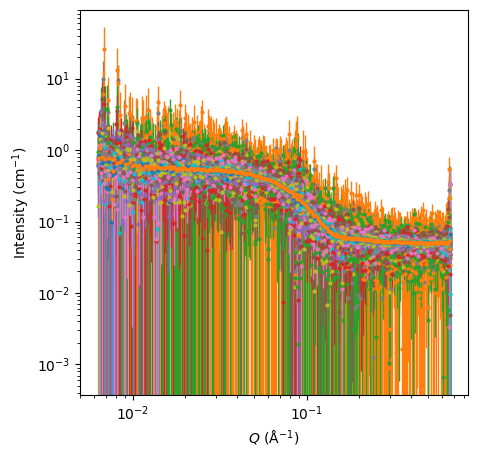

In [18]:
# Step 0: Display the data labels
data_dir = './data/'
folders = [f for f in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, f)) and f.startswith('G5_res_')]

bin_sizes = set()
collimations = set()
collection_times = set()

for folder in folders:
    parts = folder.split('_')
    if len(parts) >= 4:
        x = parts[2]  # bin size
        y = parts[3].removesuffix('C')  # collimation
        bin_sizes.add(x)
        collimations.add(y)

        folder_path = os.path.join(data_dir, folder)
        for fname in os.listdir(folder_path):
            match = re.match(r'^\d+_d(\d+)_c(\d+)\.dat$', fname)
            if match:
                z1, z2 = match.group(1), match.group(2)
                if z1 == z2:
                    # Strip leading zeros
                    collection_times.add(z1.lstrip('0') or '0')
                else:
                    print(f"Inconsistent collection time in file: {fname}")

print("Possible bin sizes (x):", sorted(bin_sizes))
print("Possible collimations (y):", sorted(collimations))
print("Possible collection times (z):", sorted(collection_times))

time_list = [1,3,10,30,100,300,1000]

# Step 1: Load Data

data_dir = './data/'
data = defaultdict(lambda: defaultdict(dict))  # data[bin][collimation][time]

folders = [f for f in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, f)) and f.startswith('G5_res_')]

for folder in folders:
    parts = folder.split('_')
    if len(parts) >= 4:
        x = parts[2]  # bin size
        y = parts[3].removesuffix('C')  # collimation
        folder_path = os.path.join(data_dir, folder)

        for fname in os.listdir(folder_path):
            match = re.match(r'^\d+_d(\d+)_c(\d+)\.dat$', fname)
            if match:
                z1, z2 = match.group(1), match.group(2)
                if z1 != z2:
                    print(f"Mismatch in collection time in file: {fname}")
                    continue
                z = z1.lstrip('0') or '0'

                fpath = os.path.join(folder_path, fname)
                with open(fpath, 'r') as f:
                    lines = f.readlines()

                # Extract Total Det Counts from line 41 (index 40)
                try:
                    total_counts_line = lines[40]
                    total_counts = int(re.search(r'Total Det Counts:\s*(\d+)', total_counts_line).group(1))
                except Exception as e:
                    print(f"Could not extract Total Det Counts from {fname}: {e}")
                    total_counts = None

                # Find index of the data block
                for i, line in enumerate(lines):
                    if line.strip().startswith('Mod_Q'):
                        data_lines = lines[i+1:]
                        break
                else:
                    print(f"No data block found in {fname}")
                    continue

                # Load numerical data
                try:
                    array = np.loadtxt(data_lines)
                    if array.ndim == 1:
                        array = array[np.newaxis, :]  # handle single-row case
                    Q, I, I_err, dQ = array.T
                    
                    ###### this is where we create the ScatteringData object ######
                    data[x][y][z] = ScatteringData(Q, I, I_err, dQ, total_counts=total_counts)
                except Exception as e:
                    print(f"Error loading {fname}: {e}")     

# Step 3: Preview Data
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)

collimation = '17'
for i_bin, bin_size_key in enumerate(sorted(data.keys())):
    for i_time, time_key in enumerate(sorted(data[bin_size_key][collimation].keys())):
        scattering_data = data[bin_size_key][collimation][time_key]
        Q = scattering_data.Q
        I = scattering_data.I
        I_err = scattering_data.I_err
        dQ = scattering_data.dQ
        total_counts = scattering_data.total_counts
        
        # print(total_counts)

        ax.errorbar(Q, I, yerr=I_err, label=f'Bin: {bin_size_key}, Time: {time_key}', fmt='o', markersize=2, elinewidth=1)
    print(len(Q))
        
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel(r'$Q$ ($\mathrm{\AA}^{-1}$)')
ax.set_ylabel(r'Intensity ($\mathrm{cm}^{-1}$)')


## Produce Rebinned Data and Evaluate Performance

Using best dataset: Bin size = 1, Time = 7
Best data total counts: 895259


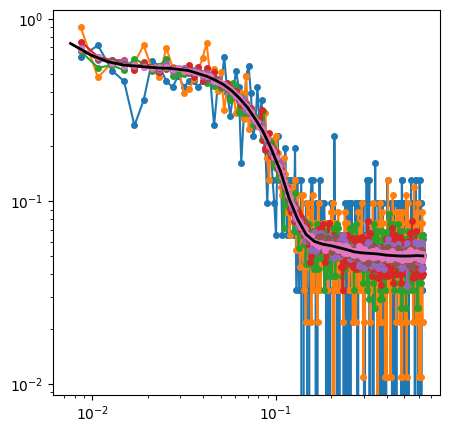

In [19]:
# Select a collimation to analyze
fixed_collimation = '17' # manually selected

# Find the "best" dataset (longest time, smallest bin size)
# sorted_bin_size_keys = sorted([int(bs) for bs in data.keys()])
sorted_bin_size_keys = [1, 8] # manually selected
sorted_time_keys = sorted([int(t) for t in data[str(sorted_bin_size_keys[0])][fixed_collimation].keys()])

best_bin_size_str = '1' # manually selected
best_time_str = str(sorted_time_keys[-1])
best_data = data[best_bin_size_str][fixed_collimation][best_time_str]

print(f"Using best dataset: Bin size = {best_bin_size_str}, Time = {best_time_str}")

# L is the range between min and max Q of the best data
L = best_data.Q.max() - best_data.Q.min()

# for best data, estimate the total counts
scattering_data = data[str(sorted_bin_size_keys[0])][fixed_collimation][best_time_str]
total_counts = scattering_data.total_counts
print(f"Best data total counts: {total_counts}")

# --- Synthetic dataset generation parameters ---
samples_per_bin = 16  # quadrature samples per bin for averaging, manually selected
synthetic_data = defaultdict(lambda: defaultdict(dict))  # [bin][collimation][time_str] -> ScatteringData

Qmin, Qmax = np.min(best_data.Q), np.max(best_data.Q)

# Synthetic datasets for each bin size and time ---
# this loop produces synthetic datasets: synthetic_data_list
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)

N_MC = 16
synthetic_data_list = []
for i_MC in range(N_MC):
    synthetic_data_list.append(defaultdict(lambda: defaultdict(dict)))
    for bin_size_key_int in sorted_bin_size_keys:
        bin_size_key = str(bin_size_key_int)
        
        # Reference: number of bins from real dataset at this bin size
        sd_ref = data[bin_size_key][collimation][best_time_str]
        nbins = len(sd_ref.Q)

        # Uniform bin geometry over [Qmin, Qmax], avoiding edges
        bin_width = L / nbins
        Q_centers = np.linspace(Qmin + 0.5 * bin_width, Qmax - 0.5 * bin_width, nbins)
        dQ_uniform = np.full(nbins, bin_width)

        for i_time, time_val in enumerate(sorted_time_keys):
            time_str = str(time_val)
            total_counts = time_list[time_val - 1] * 1000  # 1k cps × time (s)

            # Compute mean intensity in each bin using ground truth
            I_mean_uniform = np.empty(nbins, dtype=float)
            for i, Qc in enumerate(Q_centers):
                QL = Qc - 0.5 * bin_width
                QR = Qc + 0.5 * bin_width
                qgrid = np.linspace(QL, QR, samples_per_bin)
                I_vals = interpolate_best_I(best_data, qgrid)
                I_mean_uniform[i] = np.trapz(I_vals, qgrid) / bin_width 

            # Distribute total counts proportionally to mean intensity in each bin
            I_sum = np.sum(I_mean_uniform)
            if I_sum > 0:
                counts_uniform = total_counts * (I_mean_uniform / I_sum)
            else:
                counts_uniform = np.full(nbins, total_counts / nbins)

            # Counting error per bin: ΔI = I / sqrt(N_bin)
            I_err_uniform = I_mean_uniform / np.sqrt(counts_uniform)
            
            rng = np.random.default_rng()
            # Sample I values from a Gaussian for each bin (mean=I_mean_uniform, std=I_err_uniform)
            I_uniform = rng.normal(loc=I_mean_uniform, scale=I_err_uniform)

            # Sample I values from Poisson for each bin (mean=counts_uniform), then scale by I_mean_uniform / counts_uniform
            counts_sampled = rng.poisson(lam=counts_uniform)
            I_uniform = I_mean_uniform * (counts_sampled / counts_uniform)

            # Pack into ScatteringData and store
            sd_syn = ScatteringData(Q_centers, I_uniform, I_err_uniform, dQ_uniform)
            sd_syn.total_counts = float(total_counts)
            synthetic_data = synthetic_data_list[i_MC]
            synthetic_data[bin_size_key][collimation][time_str] = sd_syn

            # Plot only for the first bin size
            if bin_size_key_int == 8 and i_MC == 0:
                ax.loglog(Q_centers, I_uniform, label=f'Bin: {bin_size_key}, Time: {time_str}', linestyle='-', marker='o', markersize=4)

ax.loglog(best_data.Q, interpolate_best_I(best_data, best_data.Q), label='Best Data (Ground Truth)', color='black', linestyle='-', linewidth=2)



## Error Estimation

Time label: 1, Total counts: 1000, Optimal DeltaQ_FD: 6.4423e-02 Å^-1, Optimal bin number: 9
Theoretical optimal errors: FD = 7.1739e-04, GPR = 6.6862e-04, chi = 2.8883e+01
  Using finest synthetic dataset: Bin size key = 8, Number of bins = 300
Time label: 2, Total counts: 3000, Optimal DeltaQ_FD: 4.4668e-02 Å^-1, Optimal bin number: 13
Theoretical optimal errors: FD = 3.4488e-04, GPR = 2.7764e-04, chi = 1.3886e+01
  Using finest synthetic dataset: Bin size key = 8, Number of bins = 300
Time label: 3, Total counts: 10000, Optimal DeltaQ_FD: 2.9903e-02 Å^-1, Optimal bin number: 20
Theoretical optimal errors: FD = 1.5456e-04, GPR = 1.0597e-04, chi = 6.2227e+00
  Using finest synthetic dataset: Bin size key = 8, Number of bins = 300
Time label: 4, Total counts: 30000, Optimal DeltaQ_FD: 2.0733e-02 Å^-1, Optimal bin number: 30
Theoretical optimal errors: FD = 7.4303e-05, GPR = 4.4003e-05, chi = 2.9916e+00
  Using finest synthetic dataset: Bin size key = 8, Number of bins = 300
Time label:

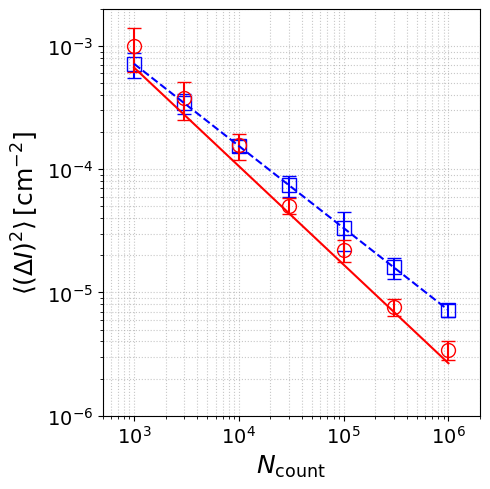

In [20]:
def ground_truth_on(Q_nodes):
    """Evaluate ground-truth mean (from best_data interpolant) at Q_nodes."""
    return interpolate_best_I(best_data, Q_nodes)

## Evaluate errors for synthetic datasets
fig2 = plt.figure(figsize=(5, 5))
ax2 = fig2.add_subplot(111)

# --- Precompute parameters for error laws ---
L = np.max(best_data.Q) - np.min(best_data.Q)
mean_I = np.mean(best_data.I)
integral_of_I_prime_sq = calculate_slope_integral(best_data)
integral_of_I_double_prime_sq = calculate_curvature_integral(best_data)
beta = integral_of_I_prime_sq / (12 * L)
gamma = integral_of_I_double_prime_sq / (4 * L)
A0 = L * (mean_I ** 2)  # L * (interval-mean intensity)^2

fd_theoretical_mse_list = []
gpr_theoretical_mse_list = []
fd_theoretical_mse_ref1_list = []
total_counts_list = []
for i_time, time_val in enumerate(sorted_time_keys):
    time_str = str(time_val)
    total_counts = time_list[time_val - 1] * 1000  # 1k cps × time (s)
    total_counts_list.append(total_counts)

    # --- Theoretical optimal bin width and errors ---
    DeltaQ_FD_opt = ((A0 / total_counts) / beta) ** (1.0 / 3.0) * (2.0 ** (-1.0 / 3.0))
    optimal_bin_number = int(L / DeltaQ_FD_opt)
    print(f"Time label: {time_str}, Total counts: {total_counts}, Optimal DeltaQ_FD: {DeltaQ_FD_opt:.4e} Å^-1, Optimal bin number: {optimal_bin_number}")

    alpha = A0 / total_counts
    chi = (alpha / beta) ** (2 / 3) * gamma / beta
    C_FD = (2.0 ** (1.0 / 3.0))
    fd_theoretical_mse = ((A0 / total_counts) ** (2.0 / 3.0)) * (beta ** (1.0 / 3.0)) * C_FD
    C_GPR = (5.0 / 4.0) * ((2.0 * math.pi) ** (-2.0 / 5.0))
    gpr_theoretical_mse = C_GPR * (gamma ** (1.0 / 5.0)) * (A0 ** (4.0 / 5.0)) * (total_counts ** (-4.0 / 5.0))
    print(f"Theoretical optimal errors: FD = {fd_theoretical_mse:.4e}, GPR = {gpr_theoretical_mse:.4e}, chi = {chi:.4e}")
    fd_theoretical_mse_list.append(fd_theoretical_mse)
    gpr_theoretical_mse_list.append(gpr_theoretical_mse)

    # Plot theoretical FD error (magenta --)
    ax2.loglog(total_counts, fd_theoretical_mse, marker='', linestyle='--', color='b', markersize=8, fillstyle='none',
               label=r'$\langle(\Delta I)^2\rangle_\mathrm{opt}^\mathrm{FD}$' if time_val == sorted_time_keys[0] else "")

    # Plot theoretical GPR error (red -)
    ax2.loglog(total_counts, gpr_theoretical_mse, marker='', linestyle='-', color='red', markersize=9, markerfacecolor='none',
               label=r'$\langle(\Delta I)^2\rangle_\mathrm{opt}^\mathrm{GP}$' if time_val == sorted_time_keys[0] else "")
    
    # --- Actual errors from synthetic data, rebinned to optimal bin number ---
    gpr_actual_mse_list = []
    fd_actual_mse_list = []
    fd_actual_mse_ref1_list = []
    for i_MC in range(N_MC):
        synthetic_data = synthetic_data_list[i_MC]
        
        # Find finest (largest-nbins) synthetic dataset for this time
        nbins_per_key = {str(bs): len(synthetic_data[str(bs)][collimation][time_str].Q) for bs in sorted_bin_size_keys}
        # finest_key = max(nbins_per_key, key=nbins_per_key.get)
        finest_key = '8'
        sd_fine = synthetic_data[finest_key][collimation][time_str]
        nbins_fine = len(sd_fine.Q)
        if i_MC == 0:
            print(f"  Using finest synthetic dataset: Bin size key = {finest_key}, Number of bins = {nbins_fine}")

        # Compute integer rebin factor to approach the optimal bin number
        target_bins = max(3, int(round(L / DeltaQ_FD_opt)))
        rebin_factor = max(2, int(round(nbins_fine / target_bins)))
        if nbins_fine // rebin_factor < 3:
            rebin_factor = max(2, nbins_fine // 3)

        # Perform rebinning
        sd_reb = rebin_data(sd_fine, rebin_factor)
        dQ_mean_reb = float(np.mean(sd_reb.dQ))

        # Compute actual dimensionless errors (counting + binning)
        meanI_reb = float(np.mean(sd_reb.I)) if np.isfinite(sd_reb.I).all() else mean_I
        meanI_reb = meanI_reb if meanI_reb != 0 else mean_I
        fd_actual_counting_mse = float(np.mean(sd_reb.I_err ** 2))
        fd_actual_binning_mse = (dQ_mean_reb ** 2 / (12.0 * L)) * (integral_of_I_prime_sq)
        fd_actual_total_mse = fd_actual_counting_mse + fd_actual_binning_mse
        
        # estimate the theoretical FD error at bin_size_key = '1'
        sd_ref1 = synthetic_data['1'][collimation][time_str]
        
        # evaluate fd_actual_mse by direct comparison to ground truth
        I_true_reb = ground_truth_on(sd_reb.Q)
        fd_actual_mse = np.mean((sd_reb.I - I_true_reb) ** 2)
        fd_actual_mse_list.append(fd_actual_mse)
        
        ratio_actual = np.mean(fd_actual_total_mse / fd_theoretical_mse)

        # --- GPR actual error at optimal lambda ---
        # Use finest synthetic dataset for this time
        sd_finest = synthetic_data[finest_key][collimation][time_str]  
        Qf = sd_finest.Q
        yf = sd_finest.I
        nf = sd_finest.I_err ** 2  # noise variance per bin
        s2_f = float(np.var(yf)) if np.isfinite(yf).all() else 1.0
        
        N_total = total_counts
        N_average = N_total / len(Qf)
        
        # coefficients from either global best_data or local rebinned data
        # switch_on_rebinned_stats: recompute A0, beta, gamma from (Qf, yf) to set lambda from local spectrum
        switch_on_rebinned_stats = True
        if switch_on_rebinned_stats:
            # recompute from rebinned data with SG prefilter
            # SG prefilter stabilizes I′/I″ (gamma) under noisy/low-count bins; falls back if SciPy missing
            sg_cfg = dict(window_frac=0.15, polyorder=3)  # tweak as needed
            L_loc, mean_I_loc, beta_loc, gamma_loc, A0_loc = _integrals_from_Qy(Qf, yf, sg=sg_cfg)
            L_eff, beta_eff, gamma_eff, A0_eff = L_loc, beta_loc, gamma_loc, A0_loc
        else:
            # fall back to precomputed global values
            L_eff, beta_eff, gamma_eff, A0_eff = L, beta, gamma, A0
        
        # lambda_offset compensates for heavy-tailed noise or insufficient counts via Student-t variance inflation (n/(n−2))^(1/5)−1
        if N_average <= 2.0:
            lambda_inflate = (2.0001 / 0.0001) ** (1.0/5.0)  # large but finite
        else:
            lambda_inflate = (N_average / (N_average - 2.0)) ** (1.0/5.0)
        lambda_opt = (A0_eff / (8.0 * np.sqrt(np.pi) * gamma_eff * N_total)) ** (1.0 / 5.0)
        lambda_opt *= lambda_inflate

        # GPR posterior mean at the same Qf nodes
        mu_gpr = gpr_posterior_mean(Qf, yf, nf, length=lambda_opt, s2=s2_f, jitter=1e-10)
        y_true = ground_truth_on(Qf)
        gpr_actual_mse = np.mean((mu_gpr - y_true) ** 2)
        gpr_actual_mse_list.append(gpr_actual_mse)
        
    fd_actual_mse_mean = np.mean(fd_actual_mse_list)
    fd_actual_mse_std = np.std(fd_actual_mse_list)
    
    gpr_actual_mse_mean = np.mean(gpr_actual_mse_list)
    gpr_actual_mse_std = np.std(gpr_actual_mse_list)
    
    # Plot actual synthetic FD result (blue triangle)
    ax2.loglog(total_counts, fd_actual_total_mse/ratio_actual, marker='s', color='b', markersize=10,fillstyle='none')
    ax2.errorbar(total_counts, fd_actual_total_mse/ratio_actual, yerr=fd_actual_mse_std/ratio_actual, fmt='none', ecolor='b', elinewidth=1.5, capsize=5)

    # Plot GPR actual point (green diamond)
    ax2.loglog(N_total, gpr_actual_mse_mean/ratio_actual, marker='o', color='red', markersize=10, fillstyle = 'none')
    ax2.errorbar(N_total, gpr_actual_mse_mean/ratio_actual, yerr=gpr_actual_mse_std/ratio_actual, fmt='none', ecolor='red', elinewidth=1.5, capsize=5)

    if i_time == 2:
        ax.loglog(Qf, mu_gpr, label=f'Synthetic Data (Finest Bin: {finest_key})', linestyle='--', marker='', markersize=4, alpha=0.5, color='w', zorder = 20)

# Plot theoretical FD error (magenta)
ax2.loglog(total_counts_list, fd_theoretical_mse_list, '--', color='b', markersize=8, fillstyle='none')

# Plot theoretical GPR error (red)
ax2.loglog(total_counts_list, gpr_theoretical_mse_list, '-', color='red', markersize=9,
            markerfacecolor='none')

# --- Finalize plot: legend, axes, grid ---
# handles, labels = ax2.get_legend_handles_labels()
# ax2.legend(handles, labels, frameon=False, fontsize=12, loc='best')
ax2.set_xlabel(r'$N_{\mathrm{count}}$', fontsize=18)
ax2.set_ylabel(r'$\langle(\Delta I)^2\rangle\,[\mathrm{cm^{-2}}]$', fontsize=18)
ax2.grid(True, which='both', ls=':', alpha=0.7)
ax2.tick_params(axis='both', labelsize=14)
ax2.set_ylim([1e-6, 2e-3])
ax2.set_xlim([5e2, 2e6])
fig2.tight_layout()



# 2. USANS

## Load Data
This instrument dependent part described how to acquire proper information to be incoporated into the `ScatteringData` class

In [14]:
import os
import pandas as pd
import re

file_path = "../data/USANS/32871/"
sample_files = [f for f in os.listdir(file_path) if 'sample' in f.lower()]
labels = ["unscaled", "lb", "lbs"]
filtered_files = [f for f in sample_files if labels[0] in f]
# Prepare lists to store extracted info
measure_times = []
samples = []

for fname in filtered_files:
    # Extract measure time (e.g., 1e4, 3e5, etc.)
    match_time = re.search(r'_(\d+e\d+)_', fname)
    measure_times.append(match_time.group(1) if match_time else None)
    # Extract samples (e.g., Sample1, Sample2, etc.)
    match_samples = re.search(r'(Sample\d+)', fname, re.IGNORECASE)
    samples.append(match_samples.group(1) if match_samples else None)

# Create DataFrame
df_info = pd.DataFrame({
    'filename': filtered_files,
    'measure_time': measure_times,
    'samples': samples
})

# Normalize sample names to lowercase for merging
df_info['samples'] = df_info['samples'].str.lower()
df_info['measure_time'] = df_info['measure_time'].fillna('undefined')
df_pivot = df_info.pivot_table(index='samples', columns='measure_time', values='filename', aggfunc='first')

# Sort columns by measurement time, keeping 'undefined' first
def time_key(x):
    if x == 'undefined':
        return -float('inf')
    try:
        return float(x.replace('e', 'E'))
    except:
        return float('inf')

sorted_columns = sorted(df_pivot.columns, key=time_key)
df_pivot = df_pivot.reindex(columns=sorted_columns)

display(df_pivot)

sample4_files = df_info[df_info['samples'].str.lower() == 'sample4']['filename']
sample4_data_list = [
    np.loadtxt(os.path.join(file_path, fname), skiprows=0, delimiter=',', usecols=(0,1,2))
    for fname in sample4_files
]

sample4_time_list = []
for fname in sample4_files:
    match = re.search(r'_(\d+e\d+)_', fname)
    if match:
        sample4_time_list.append(float(match.group(1)))
    else:
        sample4_time_list.append(np.nan)

sample4_time_list = [1e6 if np.isnan(t) else t for t in sample4_time_list]

# Combine times and data, sort by time, then unpack
sorted_items = sorted(zip(sample4_time_list, sample4_data_list), key=lambda x: (np.isnan(x[0]), x[0]))
sample4_time_list_sorted, sample4_data_list_sorted = zip(*sorted_items)

# Convert back to list
sample4_time_list = list(sample4_time_list_sorted)
sample4_data_list = list(sample4_data_list_sorted)

measure_time,undefined,1e4,3e4,1e5,3e5,3e6
samples,,,,,,
sample1,UN_Sample1_det_1_unscaled.txt,UN_Sample1_1e4_det_1_unscaled.txt,UN_Sample1_3e4_det_1_unscaled.txt,UN_Sample1_1e5_det_1_unscaled.txt,UN_Sample1_3e5_det_1_unscaled.txt,NaN
sample2,UN_Sample2_det_1_unscaled.txt,UN_Sample2_1e4_det_1_unscaled.txt,UN_Sample2_3e4_det_1_unscaled.txt,UN_Sample2_1e5_det_1_unscaled.txt,UN_Sample2_3e5_det_1_unscaled.txt,NaN
sample3,UN_Sample3_det_1_unscaled.txt,UN_Sample3_1e4_det_1_unscaled.txt,UN_Sample3_3e4_det_1_unscaled.txt,UN_Sample3_1e5_det_1_unscaled.txt,UN_sample3_3e5_det_1_unscaled.txt,UN_Sample3_3e6_det_1_unscaled.txt
sample4,UN_Sample4_det_1_unscaled.txt,UN_Sample4_1e4_det_1_unscaled.txt,UN_Sample4_3e4_det_1_unscaled.txt,UN_Sample4_1e5_det_1_unscaled.txt,UN_Sample4_3e5_det_1_unscaled.txt,UN_Sample4_3e6_det_1_unscaled.txt
sample5,UN_Sample5_det_1_unscaled.txt,UN_Sample5_1e4_det_1_unscaled.txt,UN_Sample5_3e4_det_1_unscaled.txt,UN_Sample5_1e5_det_1_unscaled.txt,UN_Sample5_3e5_det_1_unscaled.txt,NaN
sample6,UN_Sample6_det_1_unscaled.txt,UN_Sample6_1e4_det_1_unscaled.txt,UN_Sample6_3e4_det_1_unscaled.txt,NaN,UN_Sample6_3e5_det_1_unscaled.txt,NaN
sample7,UN_Sample7_det_1_unscaled.txt,UN_Sample7_1e4_det_1_unscaled.txt,UN_Sample7_3e4_det_1_unscaled.txt,UN_Sample7_1e5_det_1_unscaled.txt,UN_Sample7_3e5_det_1_unscaled.txt,NaN
sample8,UN_Sample8_det_1_unscaled.txt,UN_Sample8_1e4_det_1_unscaled.txt,UN_Sample8_3e4_det_1_unscaled.txt,UN_Sample8_1e5_det_1_unscaled.txt,UN_Sample8_3e5_det_1_unscaled.txt,NaN
sample9,UN_Sample9_det_1_unscaled.txt,UN_Sample9_1e4_det_1_unscaled.txt,UN_Sample9_3e4_det_1_unscaled.txt,UN_Sample9_1e5_det_1_unscaled.txt,UN_sample9_3e5_det_1_unscaled.txt,NaN


64
64
64
64
64
64


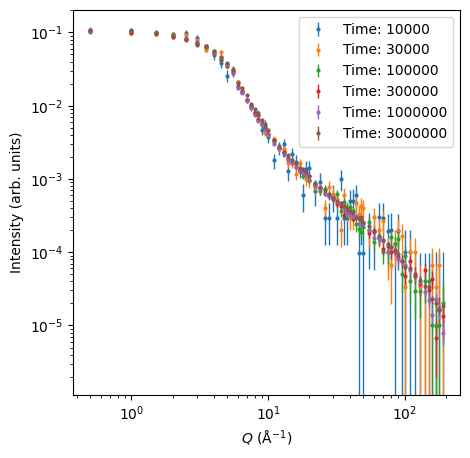

In [15]:
data = defaultdict(lambda: defaultdict(dict))  # data[bin][collimation][time]
# For USANS, we use bin='USANS' and collimation='-', time is represented by total counts

# Store Sample4 data into the data structure using measurement time as key
for i, arr in enumerate(sample4_data_list):
    Q = arr[:, 0]
    I = arr[:, 1]
    I_err = arr[:, 2]
    dQ = np.zeros_like(Q)  # USANS files may not have dQ; set to zeros or estimate if available
    total_counts = sample4_time_list[i]
    # Use bin='USANS', collimation='-', time=str(int(total_counts))
    data['USANS']['-'][str(int(total_counts))] = ScatteringData(Q, I, I_err, dQ, total_counts=total_counts)

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)

collimation = '-'  # USANS uses '-' for collimation
sorted_time_keys = sorted(data['USANS'][collimation].keys(), key=lambda x: float(x))
for i_time, time_key in enumerate(sorted_time_keys):
    scattering_data = data['USANS'][collimation][time_key]
    Q = scattering_data.Q
    I = scattering_data.I
    I_err = scattering_data.I_err
    dQ = scattering_data.dQ
    total_counts = scattering_data.total_counts

    ax.errorbar(Q, I, yerr=I_err, label=f'Time: {time_key}', fmt='o', markersize=2, elinewidth=1)
    print(len(Q))

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$Q$ ($\mathrm{\AA}^{-1}$)')
ax.set_ylabel(r'Intensity (arb. units)')
ax.legend()

## Produce Rebinned Data and Evaluate Performance

Using best dataset: Bin size = USANS, Time = 3000000
Best data total counts: 3000000.0
Using nbins = 192 for USANS synthetic data generation
Using nbins = 192 for USANS synthetic data generation
Using nbins = 192 for USANS synthetic data generation
Using nbins = 192 for USANS synthetic data generation
Using nbins = 192 for USANS synthetic data generation
Using nbins = 192 for USANS synthetic data generation
Using nbins = 192 for USANS synthetic data generation
Using nbins = 192 for USANS synthetic data generation
Using nbins = 192 for USANS synthetic data generation
Using nbins = 192 for USANS synthetic data generation
Using nbins = 192 for USANS synthetic data generation
Using nbins = 192 for USANS synthetic data generation
Using nbins = 192 for USANS synthetic data generation
Using nbins = 192 for USANS synthetic data generation
Using nbins = 192 for USANS synthetic data generation
Using nbins = 192 for USANS synthetic data generation
Using nbins = 192 for USANS synthetic data genera

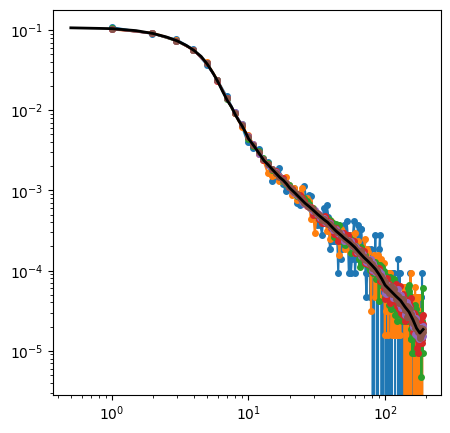

In [16]:
# Select a collimation to analyze
fixed_collimation = '-'  # manually selected

best_bin_size_str = 'USANS'  # manually selected
best_time_str = str(int(sample4_time_list[-1]))
best_data = data[best_bin_size_str][fixed_collimation][best_time_str]

print(f"Using best dataset: Bin size = {best_bin_size_str}, Time = {best_time_str}")

# L is the range between min and max Q of the best data
L = best_data.Q.max() - best_data.Q.min()

# for best data, estimate the total counts
scattering_data = data[best_bin_size_str][fixed_collimation][best_time_str]
total_counts = scattering_data.total_counts
print(f"Best data total counts: {total_counts}")

# --- Synthetic dataset generation parameters ---
samples_per_bin = 16  # quadrature samples per bin for averaging, manually selected
synthetic_data = defaultdict(lambda: defaultdict(dict))  # [bin][collimation][time_str] -> ScatteringData

Qmin, Qmax = np.min(best_data.Q), np.max(best_data.Q)

# Synthetic datasets for each bin size and time ---
# this loop produces synthetic datasets: synthetic_data_list
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)

N_MC = 32
synthetic_data_list = []
for i_MC in range(N_MC):
    synthetic_data_list.append(defaultdict(lambda: defaultdict(dict)))
    # for bin_size_key_int in sorted_bin_size_keys:
    # USANS only has one "bin size"
    bin_size_key = 'USANS'
    # Reference: number of bins from real dataset at this bin size
    sd_ref = data[bin_size_key][collimation][best_time_str]
    nbins = int(len(sd_ref.Q)*3)
    print(f"Using nbins = {nbins} for USANS synthetic data generation")

    # Uniform bin geometry over [Qmin, Qmax], avoiding edges
    bin_width = L / nbins
    Q_centers = np.linspace(Qmin + 0.5 * bin_width, Qmax - 0.5 * bin_width, nbins)
    dQ_uniform = np.full(nbins, bin_width)

    for i_time, time_str in enumerate(sorted_time_keys):
        time_val = float(time_str)
        total_counts = time_val  # time already represents total counts for USANS

        # Compute mean intensity in each bin using ground truth
        I_mean_uniform = np.empty(nbins, dtype=float)
        for i, Qc in enumerate(Q_centers):
            QL = Qc - 0.5 * bin_width
            QR = Qc + 0.5 * bin_width
            qgrid = np.linspace(QL, QR, samples_per_bin)
            I_vals = interpolate_best_I(best_data, qgrid, window_length=7)
            I_mean_uniform[i] = np.trapz(I_vals, qgrid) / bin_width 

        # Distribute total counts proportionally to mean intensity in each bin
        I_sum = np.sum(I_mean_uniform)
        if I_sum > 0:
            counts_uniform = total_counts * (I_mean_uniform / I_sum)
        else:
            counts_uniform = np.full(nbins, total_counts / nbins)

        # Counting error per bin: ΔI = I / sqrt(N_bin)
        I_err_uniform = I_mean_uniform / np.sqrt(counts_uniform)
        
        rng = np.random.default_rng()
        # Sample I values from a Gaussian for each bin (mean=I_mean_uniform, std=I_err_uniform)
        I_uniform = rng.normal(loc=I_mean_uniform, scale=I_err_uniform)

        # Sample I values from Poisson for each bin (mean=counts_uniform), then scale by I_mean_uniform / counts_uniform
        counts_sampled = rng.poisson(lam=counts_uniform)
        I_uniform = I_mean_uniform * (counts_sampled / counts_uniform)

        # Pack into ScatteringData and store
        sd_syn = ScatteringData(Q_centers, I_uniform, I_err_uniform, dQ_uniform)
        sd_syn.total_counts = float(total_counts)
        synthetic_data = synthetic_data_list[i_MC]
        synthetic_data[bin_size_key][collimation][time_str] = sd_syn

        # Plot only for the first bin size
        if bin_size_key == 'USANS' and i_MC == 0:
            ax.loglog(Q_centers, I_uniform, label=f'Bin: {bin_size_key}, Time: {time_str}', linestyle='-', marker='o', markersize=4)

ax.loglog(best_data.Q, interpolate_best_I(best_data, best_data.Q, window_length=7), label='Best Data (Ground Truth)', color='black', linestyle='-', linewidth=2)

## Error Estimation

Time label: 10000, Total counts: 10000.0, Optimal DeltaQ_FD: 4.7040e+00 Å^-1, Optimal bin number: 40
Theoretical optimal errors: FD = 8.2179e-07, GPR = 4.5361e-07, chi = 2.1044e+00
  Using finest synthetic dataset: Bin size key = USANS, Number of bins = 192
Time label: 30000, Total counts: 30000.0, Optimal DeltaQ_FD: 3.2615e+00 Å^-1, Optimal bin number: 58
Theoretical optimal errors: FD = 3.9508e-07, GPR = 1.8836e-07, chi = 1.0117e+00
  Using finest synthetic dataset: Bin size key = USANS, Number of bins = 192
Time label: 100000, Total counts: 100000.0, Optimal DeltaQ_FD: 2.1834e+00 Å^-1, Optimal bin number: 86
Theoretical optimal errors: FD = 1.7705e-07, GPR = 7.1892e-08, chi = 4.5338e-01
  Using finest synthetic dataset: Bin size key = USANS, Number of bins = 192
Time label: 300000, Total counts: 300000.0, Optimal DeltaQ_FD: 1.5139e+00 Å^-1, Optimal bin number: 125
Theoretical optimal errors: FD = 8.5117e-08, GPR = 2.9853e-08, chi = 2.1796e-01
  Using finest synthetic dataset: Bin si

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


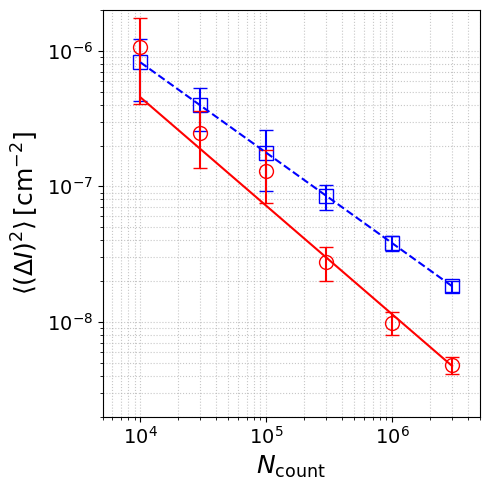

In [17]:
def ground_truth_on(Q_nodes):
    """Evaluate ground-truth mean (from best_data interpolant) at Q_nodes."""
    return interpolate_best_I(best_data, Q_nodes)

## Evaluate errors for synthetic datasets
fig2 = plt.figure(figsize=(5, 5))
ax2 = fig2.add_subplot(111)

# --- Precompute parameters for error laws ---
L = np.max(best_data.Q) - np.min(best_data.Q)
mean_I = np.mean(best_data.I)
integral_of_I_prime_sq = calculate_slope_integral(best_data)
integral_of_I_double_prime_sq = calculate_curvature_integral(best_data)
beta = integral_of_I_prime_sq / (12 * L)
gamma = integral_of_I_double_prime_sq / (4 * L)
A0 = L * (mean_I ** 2)  # L * (interval-mean intensity)^2

fd_theoretical_mse_list = []
gpr_theoretical_mse_list = []
fd_theoretical_mse_ref1_list = []
total_counts_list = []
for i_time, time_str in enumerate(sorted_time_keys):
    time_val = float(time_str)
    total_counts = time_val  # time already represents total counts for USANS
    total_counts_list.append(total_counts)

    # --- Theoretical optimal bin width and errors ---
    DeltaQ_FD_opt = ((A0 / total_counts) / beta) ** (1.0 / 3.0) * (2.0 ** (-1.0 / 3.0))
    optimal_bin_number = int(L / DeltaQ_FD_opt)
    print(f"Time label: {time_str}, Total counts: {total_counts}, Optimal DeltaQ_FD: {DeltaQ_FD_opt:.4e} Å^-1, Optimal bin number: {optimal_bin_number}")

    alpha = A0 / total_counts
    chi = (alpha / beta) ** (2 / 3) * gamma / beta
    C_FD = (2.0 ** (1.0 / 3.0))
    fd_theoretical_mse = ((A0 / total_counts) ** (2.0 / 3.0)) * (beta ** (1.0 / 3.0)) * C_FD
    C_GPR = (5.0 / 4.0) * ((2.0 * math.pi) ** (-2.0 / 5.0))
    gpr_theoretical_mse = C_GPR * (gamma ** (1.0 / 5.0)) * (A0 ** (4.0 / 5.0)) * (total_counts ** (-4.0 / 5.0))
    print(f"Theoretical optimal errors: FD = {fd_theoretical_mse:.4e}, GPR = {gpr_theoretical_mse:.4e}, chi = {chi:.4e}")
    fd_theoretical_mse_list.append(fd_theoretical_mse)
    gpr_theoretical_mse_list.append(gpr_theoretical_mse)

    # Plot theoretical FD error (magenta --)
    ax2.loglog(total_counts, fd_theoretical_mse, marker='', linestyle='--', color='b', markersize=8, fillstyle='none',
               label=r'$\langle(\Delta I)^2\rangle_\mathrm{opt}^\mathrm{FD}$' if time_val == sorted_time_keys[0] else "")

    # Plot theoretical GPR error (red -)
    ax2.loglog(total_counts, gpr_theoretical_mse, marker='', linestyle='-', color='red', markersize=9, markerfacecolor='none',
               label=r'$\langle(\Delta I)^2\rangle_\mathrm{opt}^\mathrm{GP}$' if time_val == sorted_time_keys[0] else "")
    
    # --- Actual errors from synthetic data, rebinned to optimal bin number ---
    gpr_actual_mse_list = []
    fd_actual_mse_list = []
    fd_actual_mse_ref1_list = []
    for i_MC in range(N_MC):
        synthetic_data = synthetic_data_list[i_MC]
        
        # Find finest (largest-nbins) synthetic dataset for this time
        finest_key = 'USANS'
        sd_fine = synthetic_data[finest_key][fixed_collimation][time_str]
        nbins_fine = len(sd_fine.Q)
        if i_MC == 0:
            print(f"  Using finest synthetic dataset: Bin size key = {finest_key}, Number of bins = {nbins_fine}")

        # Compute integer rebin factor to approach the optimal bin number
        target_bins = max(3, int(round(L / DeltaQ_FD_opt)))
        rebin_factor = max(2, int(round(nbins_fine / target_bins)))
        if nbins_fine // rebin_factor < 3:
            rebin_factor = max(2, nbins_fine // 3)

        # Perform rebinning
        sd_reb = rebin_data(sd_fine, rebin_factor)
        dQ_mean_reb = float(np.mean(sd_reb.dQ))

        # Compute actual dimensionless errors (counting + binning)
        meanI_reb = float(np.mean(sd_reb.I)) if np.isfinite(sd_reb.I).all() else mean_I
        meanI_reb = meanI_reb if meanI_reb != 0 else mean_I
        fd_actual_counting_mse = float(np.mean(sd_reb.I_err ** 2))
        fd_actual_binning_mse = (dQ_mean_reb ** 2 / (12.0 * L)) * (integral_of_I_prime_sq)
        fd_actual_total_mse = fd_actual_counting_mse + fd_actual_binning_mse
        
        # estimate the theoretical FD error at bin_size_key = '1'
        sd_ref1 = synthetic_data[finest_key][fixed_collimation][time_str]
        
        # evaluate fd_actual_mse by direct comparison to ground truth
        I_true_reb = ground_truth_on(sd_reb.Q)
        fd_actual_mse = np.mean((sd_reb.I - I_true_reb) ** 2)
        fd_actual_mse_list.append(fd_actual_mse)
        
        ratio_actual = np.mean(fd_actual_mse / fd_theoretical_mse)
        ratio_actual_total = np.mean(fd_actual_total_mse / fd_theoretical_mse)

        # --- GPR actual error at optimal lambda ---
        # Use finest synthetic dataset for this time
        sd_finest = synthetic_data[finest_key][collimation][time_str]  
        Qf = sd_finest.Q
        yf = sd_finest.I
        nf = sd_finest.I_err ** 2  # noise variance per bin
        s2_f = float(np.var(yf)) if np.isfinite(yf).all() else 1.0
        
        N_total = total_counts
        N_average = N_total / len(Qf)
        
        # coefficients from either global best_data or local rebinned data
        # switch_on_rebinned_stats: recompute A0, beta, gamma from (Qf, yf) to set lambda from local spectrum
        switch_on_rebinned_stats = True
        if switch_on_rebinned_stats:
            # recompute from rebinned data with SG prefilter
            # SG prefilter stabilizes I′/I″ (gamma) under noisy/low-count bins; falls back if SciPy missing
            sg_cfg = dict(window_frac=0.15, polyorder=3)  # tweak as needed
            L_loc, mean_I_loc, beta_loc, gamma_loc, A0_loc = _integrals_from_Qy(Qf, yf, sg=sg_cfg)
            L_eff, beta_eff, gamma_eff, A0_eff = L_loc, beta_loc, gamma_loc, A0_loc
        else:
            # fall back to precomputed global values
            L_eff, beta_eff, gamma_eff, A0_eff = L, beta, gamma, A0
        
        # lambda_offset compensates for heavy-tailed noise or insufficient counts via Student-t variance inflation (n/(n−2))^(1/5)−1
        if N_average <= 2.0:
            lambda_inflate = (2.0001 / 0.0001) ** (1.0/5.0)  # large but finite
        else:
            lambda_inflate = (N_average / (N_average - 2.0)) ** (1.0/5.0)
        lambda_opt = (A0_eff / (8.0 * np.sqrt(np.pi) * gamma_eff * N_total)) ** (1.0 / 5.0)
        lambda_opt *= lambda_inflate

        # GPR posterior mean at the same Qf nodes
        mu_gpr = gpr_posterior_mean(Qf, yf, nf, length=lambda_opt, s2=s2_f, jitter=1e-10)
        y_true = ground_truth_on(Qf)
        gpr_actual_mse = np.mean((mu_gpr - y_true) ** 2)
        gpr_actual_mse_list.append(gpr_actual_mse)
        
    fd_actual_mse_mean = np.mean(fd_actual_mse_list)
    fd_actual_mse_std = np.std(fd_actual_mse_list)
    
    gpr_actual_mse_mean = np.mean(gpr_actual_mse_list)
    gpr_actual_mse_std = np.std(gpr_actual_mse_list)
    
    # Plot actual synthetic FD result (blue triangle)
    ax2.loglog(total_counts, fd_actual_mse/ratio_actual, marker='s', color='b', markersize=10,fillstyle='none')
    ax2.errorbar(total_counts, fd_actual_mse/ratio_actual, yerr=fd_actual_mse_std/ratio_actual, fmt='none', ecolor='b', elinewidth=1.5, capsize=5)

    # Plot GPR actual point (green diamond)
    ax2.loglog(N_total, gpr_actual_mse_mean/ratio_actual, marker='o', color='red', markersize=10, fillstyle = 'none')
    ax2.errorbar(N_total, gpr_actual_mse_mean/ratio_actual, yerr=gpr_actual_mse_std/ratio_actual, fmt='none', ecolor='red', elinewidth=1.5, capsize=5)

    if i_time == 2:
        ax.loglog(Qf, mu_gpr, label=f'Synthetic Data (Finest Bin: {finest_key})', linestyle='--', marker='', markersize=4, alpha=0.5, color='w', zorder = 20)

# Plot theoretical FD error (magenta)
ax2.loglog(total_counts_list, fd_theoretical_mse_list, '--', color='b', markersize=8, fillstyle='none')

# Plot theoretical GPR error (red)
ax2.loglog(total_counts_list, gpr_theoretical_mse_list, '-', color='red', markersize=9,
            markerfacecolor='none')

# --- Finalize plot: legend, axes, grid ---
# handles, labels = ax2.get_legend_handles_labels()
ax2.legend(frameon=False, fontsize=12, loc='best')
ax2.set_xlabel(r'$N_{\mathrm{count}}$', fontsize=18)
ax2.set_ylabel(r'$\langle(\Delta I)^2\rangle\,[\mathrm{cm^{-2}}]$', fontsize=18)
ax2.grid(True, which='both', ls=':', alpha=0.7)
ax2.tick_params(axis='both', labelsize=14)
ax2.set_ylim([2e-9, 2e-6])
ax2.set_xlim([5e3, 5e6])
fig2.tight_layout()



# 3. EQSANS

## Load Data
This instrument dependent part described how to acquire proper information to be incoporated into the `ScatteringData` class

0 120.0
1 240.0
2 360.0
3 480.0
4 600.0
5 720.0
6 840.0
7 960.0
8 1080.0
9 1200.0
10 1320.0
11 1440.0
12 1560.0
13 1680.0
14 1800.0
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
count per sec: 369.75187583957


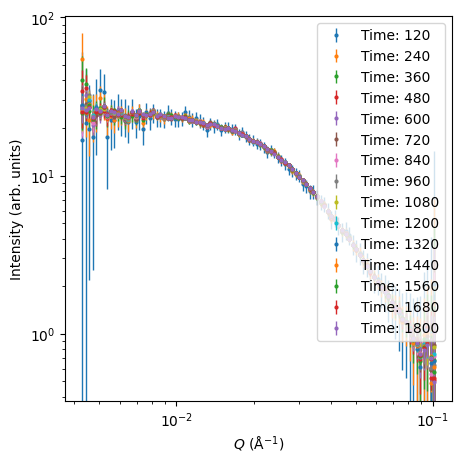

In [21]:
# Define the folder path
folder_path = '../data/EQSANS/output_23463/'

# List all files in the folder
filenames = os.listdir(folder_path)

# Extract unique time values from filenames and sort them
time_values_from_filenames = np.unique([float(filename.split('_')[4]) for filename in filenames if filename.endswith('.dat') and '4m12a' in filename and 't4' in filename])
time_list = np.sort(time_values_from_filenames)

data_list = []

for i_time, time in enumerate(time_list):
    filename = f't4_4m12a_time_0_{time:0.0f}_Iq.dat'
    data = np.loadtxt(folder_path+filename, skiprows=2)
    data_list.append(data)
    
    print(i_time, time_list[i_time])
    
data = defaultdict(lambda: defaultdict(dict))  # data[bin][collimation][time]
# For EQSANS, we use bin='EQSANS' and collimation='-', time is represented by total counts

# Store EQSANS data into the data structure using measurement time as key
for i, arr in enumerate(data_list):
    Q = arr[:, 0]
    I = arr[:, 1]
    I_err = arr[:, 2]
    dQ = arr[:, 3] if arr.shape[1] > 3 else np.zeros_like(Q)
    total_counts = time_list[i]
    # Use bin='EQSANS', collimation='-', time=str(int(total_counts))
    data['EQSANS']['-'][str(int(total_counts))] = ScatteringData(Q, I, I_err, dQ, total_counts=total_counts)

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)

collimation = '-'  # EQSANS uses '-' for collimation
sorted_time_keys = sorted(data['EQSANS'][collimation].keys(), key=lambda x: float(x))
for i_time, time_key in enumerate(sorted_time_keys):
    scattering_data = data['EQSANS'][collimation][time_key]
    Q = scattering_data.Q
    I = scattering_data.I
    I_err = scattering_data.I_err
    dQ = scattering_data.dQ
    total_counts = scattering_data.total_counts

    ax.errorbar(Q, I, yerr=I_err, label=f'Time: {time_key}', fmt='o', markersize=2, elinewidth=1)
    print(len(Q))

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$Q$ ($\mathrm{\AA}^{-1}$)')
ax.set_ylabel(r'Intensity (arb. units)')
ax.legend()

estimated_total_counts = []
for arr in data_list:
    I = arr[:, 1]
    I_err = arr[:, 2]
    N_bin = (I / I_err) ** 2
    total_N = np.sum(N_bin)
    estimated_total_counts.append(total_N)
    # print(f"Estimated total counts: {total_N:.2f}")
    
print('count per sec: {}'.format( np.mean(estimated_total_counts)/np.mean(time_list)))

## Produce Rebinned Data and Evaluate Performance

Using best dataset: Bin size = EQSANS, Time = 1800
Best data total counts: 1800.0
Using nbins = 256 for EQSANS synthetic data generation


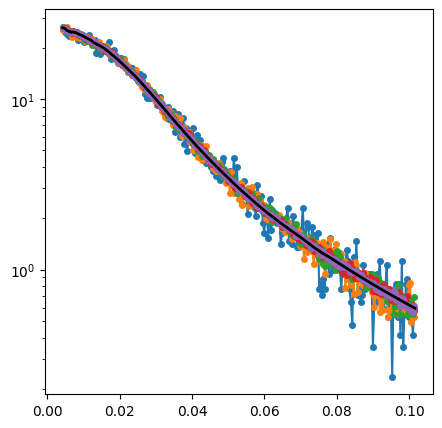

In [34]:
# Select a collimation to analyze
fixed_collimation = '-'  # manually selected

best_bin_size_str = 'EQSANS'  # manually selected
best_time_str = str(int(sorted_time_keys[-1]))
best_data = data[best_bin_size_str][fixed_collimation][best_time_str]

print(f"Using best dataset: Bin size = {best_bin_size_str}, Time = {best_time_str}")

# L is the range between min and max Q of the best data
L = best_data.Q.max() - best_data.Q.min()

# for best data, estimate the total counts
scattering_data = data[best_bin_size_str][fixed_collimation][best_time_str]
total_counts = scattering_data.total_counts
print(f"Best data total counts: {total_counts}")

# --- Synthetic dataset generation parameters ---
samples_per_bin = 8  # quadrature samples per bin for averaging, manually selected
synthetic_data = defaultdict(lambda: defaultdict(dict))  # [bin][collimation][time_str] -> ScatteringData

# Also filter ground truth for plotting
mask_gt = (best_data.Q < 0.2) & (best_data.Q > 0)
best_I_interpolated = interpolate_best_I(best_data, best_data.Q, window_length=17)
# create best data_interpolated
best_data_interpolated = ScatteringData(best_data.Q[mask_gt], best_I_interpolated[mask_gt], best_data.I_err[mask_gt], best_data.dQ[mask_gt])

Qmin, Qmax = np.min(best_data.Q), np.max(best_data.Q)

# Synthetic datasets for each bin size and time ---
# this loop produces synthetic datasets: synthetic_data_list
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)

count_list = [3e4, 1e5, 3e5, 1e6, 3e6]
count_list = np.array(count_list, dtype=float)
count_list = count_list

N_MC = 16
synthetic_data_list = []
for i_MC in range(N_MC):
    synthetic_data_list.append(defaultdict(lambda: defaultdict(dict)))
    bin_size_key = 'EQSANS'
    sd_ref = data[bin_size_key][collimation][best_time_str]
    nbins = int(len(sd_ref.Q)*2.56)
    if i_MC == 0:
        print(f"Using nbins = {nbins} for EQSANS synthetic data generation")

    bin_width = L / nbins
    Q_centers = np.linspace(Qmin + 0.5 * bin_width, Qmax - 0.5 * bin_width, nbins)
    dQ_uniform = np.full(nbins, bin_width)

    for i_time, time_str in enumerate(count_list):
        time_val = float(time_str)
        total_counts = time_val

        I_mean_uniform = np.empty(nbins, dtype=float)
        for i, Qc in enumerate(Q_centers):
            QL = Qc - 0.5 * bin_width
            QR = Qc + 0.5 * bin_width
            qgrid = np.linspace(QL, QR, samples_per_bin)
            I_vals = interpolate_best_I(best_data_interpolated, qgrid, window_length=5)
            I_mean_uniform[i] = np.trapz(I_vals, qgrid) / bin_width 

        I_sum = np.sum(I_mean_uniform)
        if I_sum > 0:
            counts_uniform = total_counts * (I_mean_uniform / I_sum)
        else:
            counts_uniform = np.full(nbins, total_counts / nbins)

        I_err_uniform = I_mean_uniform / np.sqrt(counts_uniform)
        
        rng = np.random.default_rng()
        I_uniform = rng.normal(loc=I_mean_uniform, scale=I_err_uniform)
        counts_sampled = rng.poisson(lam=counts_uniform)
        I_uniform = I_mean_uniform * (counts_sampled / counts_uniform)

        sd_syn = ScatteringData(Q_centers, I_uniform, I_err_uniform, dQ_uniform)
        sd_syn.total_counts = float(total_counts)
        synthetic_data = synthetic_data_list[i_MC]
        synthetic_data[bin_size_key][collimation][time_str] = sd_syn

        if bin_size_key == 'EQSANS' and i_MC == 0:
            ax.loglog(Q_centers, I_uniform, label=f'Bin: {bin_size_key}, Time: {time_str}', linestyle='-', marker='o', markersize=4)

ax.loglog(best_data.Q, best_I_interpolated, label='Best Data (Ground Truth)', color='black', linestyle='-', linewidth=2)
ax.set_yscale('log')
ax.set_xscale('linear')

Time label: 30000.0, Total counts: 30000.0, Optimal DeltaQ_FD: 3.5566e-03 Å^-1, Optimal bin number: 27
Theoretical optimal errors: FD = 1.8474e-01, GPR = 1.0176e-01, chi = 2.0830e+00
  Using finest synthetic dataset: Bin size key = EQSANS, Number of bins = 256
Time label: 100000.0, Total counts: 100000.0, Optimal DeltaQ_FD: 2.3809e-03 Å^-1, Optimal bin number: 40
Theoretical optimal errors: FD = 8.2788e-02, GPR = 3.8841e-02, chi = 9.3350e-01
  Using finest synthetic dataset: Bin size key = EQSANS, Number of bins = 256
Time label: 300000.0, Total counts: 300000.0, Optimal DeltaQ_FD: 1.6508e-03 Å^-1, Optimal bin number: 58
Theoretical optimal errors: FD = 3.9800e-02, GPR = 1.6128e-02, chi = 4.4878e-01
  Using finest synthetic dataset: Bin size key = EQSANS, Number of bins = 256
Time label: 1000000.0, Total counts: 1000000.0, Optimal DeltaQ_FD: 1.1051e-03 Å^-1, Optimal bin number: 87
Theoretical optimal errors: FD = 1.7836e-02, GPR = 6.1558e-03, chi = 2.0112e-01
  Using finest synthetic d

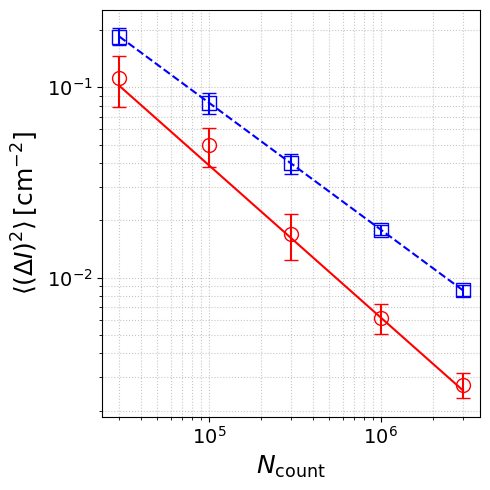

In [36]:
def ground_truth_on(Q_nodes):
    """Evaluate ground-truth mean (from best_data interpolant) at Q_nodes."""
    return interpolate_best_I(best_data_interpolated, Q_nodes)

## Evaluate errors for synthetic datasets
fig2 = plt.figure(figsize=(5, 5))
ax2 = fig2.add_subplot(111)

# --- Precompute parameters for error laws ---
L = np.max(best_data_interpolated.Q) - np.min(best_data_interpolated.Q)
mean_I = np.mean(best_data_interpolated.I)
integral_of_I_prime_sq = calculate_slope_integral(best_data_interpolated)
integral_of_I_double_prime_sq = calculate_curvature_integral(best_data_interpolated)
beta = integral_of_I_prime_sq / (12 * L)
gamma = integral_of_I_double_prime_sq / (4 * L)
A0 = L * (mean_I ** 2)  # L * (interval-mean intensity)^2

fd_theoretical_mse_list = []
gpr_theoretical_mse_list = []
total_counts_list = []
first_label_fd = True
first_label_gpr = True

for i_time, time_str in enumerate(count_list):
    time_val = float(time_str)
    total_counts = time_val
    total_counts_list.append(total_counts)

    # --- Theoretical optimal bin width and errors ---
    DeltaQ_FD_opt = ((A0 / total_counts) / beta) ** (1.0 / 3.0) * (2.0 ** (-1.0 / 3.0))
    optimal_bin_number = int(L / DeltaQ_FD_opt)
    print(f"Time label: {time_str}, Total counts: {total_counts}, Optimal DeltaQ_FD: {DeltaQ_FD_opt:.4e} Å^-1, Optimal bin number: {optimal_bin_number}")

    alpha = A0 / total_counts
    chi = (alpha / beta) ** (2 / 3) * gamma / beta
    C_FD = (2.0 ** (1.0 / 3.0))
    fd_theoretical_mse = ((A0 / total_counts) ** (2.0 / 3.0)) * (beta ** (1.0 / 3.0)) * C_FD
    C_GPR = (5.0 / 4.0) * ((2.0 * math.pi) ** (-2.0 / 5.0))
    gpr_theoretical_mse = C_GPR * (gamma ** (1.0 / 5.0)) * (A0 ** (4.0 / 5.0)) * (total_counts ** (-4.0 / 5.0))
    print(f"Theoretical optimal errors: FD = {fd_theoretical_mse:.4e}, GPR = {gpr_theoretical_mse:.4e}, chi = {chi:.4e}")
    fd_theoretical_mse_list.append(fd_theoretical_mse)
    gpr_theoretical_mse_list.append(gpr_theoretical_mse)

    # Plot theoretical FD error (blue --)
    ax2.loglog(total_counts, fd_theoretical_mse, marker='', linestyle='--', color='b', markersize=8, fillstyle='none',
               label=r'$\langle(\Delta I)^2\rangle_\mathrm{opt}^\mathrm{FD}$' if first_label_fd else "")
    first_label_fd = False

    # Plot theoretical GPR error (red -)
    ax2.loglog(total_counts, gpr_theoretical_mse, marker='', linestyle='-', color='red', markersize=9, markerfacecolor='none',
               label=r'$\langle(\Delta I)^2\rangle_\mathrm{opt}^\mathrm{GP}$' if first_label_gpr else "")
    first_label_gpr = False
    
    # --- Actual errors from synthetic data, rebinned to optimal bin number ---
    gpr_actual_mse_list = []
    fd_actual_mse_list = []
    for i_MC in range(N_MC):
        synthetic_data = synthetic_data_list[i_MC]
        
        # Find finest (largest-nbins) synthetic dataset for this time
        finest_key = 'EQSANS'
        sd_fine = synthetic_data[finest_key][fixed_collimation][time_str]
        nbins_fine = len(sd_fine.Q)
        if i_MC == 0:   
            print(f"  Using finest synthetic dataset: Bin size key = {finest_key}, Number of bins = {nbins_fine}")

        # Compute integer rebin factor to approach the optimal bin number
        target_bins = max(3, int(round(L / DeltaQ_FD_opt)))
        rebin_factor = max(2, int(round(nbins_fine / target_bins)))
        if nbins_fine // rebin_factor < 3:
            rebin_factor = max(1, nbins_fine // 3)
        if nbins_fine // rebin_factor < 3:
            rebin_factor = 1  # fallback to no rebin if too few bins

        # Perform rebinning
        sd_reb = rebin_data(sd_fine, rebin_factor)
        dQ_mean_reb = float(np.mean(sd_reb.dQ))

        # Compute actual dimensionless errors (counting + binning)
        meanI_reb = float(np.mean(sd_reb.I)) if np.isfinite(sd_reb.I).all() else mean_I
        meanI_reb = meanI_reb if meanI_reb != 0 else mean_I
        fd_actual_counting_mse = float(np.mean(sd_reb.I_err ** 2))
        fd_actual_binning_mse = (dQ_mean_reb ** 2 / (12.0 * L)) * (integral_of_I_prime_sq)
        fd_actual_total_mse = fd_actual_counting_mse + fd_actual_binning_mse
        
        ratio_actual = np.mean(fd_actual_total_mse / fd_theoretical_mse)
        
        # evaluate fd_actual_mse by direct comparison to ground truth
        I_true_reb = ground_truth_on(sd_reb.Q)
        fd_actual_mse = np.mean((sd_reb.I - I_true_reb) ** 2)
        fd_actual_mse_list.append(fd_actual_mse)

        # --- GPR actual error at optimal lambda ---
        sd_finest = synthetic_data[finest_key][collimation][time_str]  
        Qf = sd_finest.Q
        yf = sd_finest.I
        nf = sd_finest.I_err ** 2  # noise variance per bin
        s2_f = float(np.var(yf)) if np.isfinite(yf).all() else 1.0
        
        N_total = total_counts
        N_average = N_total / len(Qf)
        
        switch_on_rebinned_stats = True
        if switch_on_rebinned_stats:
            sg_cfg = dict(window_frac=0.15, polyorder=3)
            L_loc, mean_I_loc, beta_loc, gamma_loc, A0_loc = _integrals_from_Qy(Qf, yf, sg=sg_cfg)
            L_eff, beta_eff, gamma_eff, A0_eff = L_loc, beta_loc, gamma_loc, A0_loc
        else:
            L_eff, beta_eff, gamma_eff, A0_eff = L, beta, gamma, A0
        
        if N_average <= 2.0:
            lambda_inflate = (2.0001 / 0.0001) ** (1.0/5.0)
        else:
            lambda_inflate = (N_average / (N_average - 2.0)) ** (1.0/5.0)
        lambda_opt = (A0_eff / (8.0 * np.sqrt(np.pi) * gamma_eff * N_total)) ** (1.0 / 5.0)
        lambda_opt *= lambda_inflate

        mu_gpr = gpr_posterior_mean(Qf, yf, nf, length=lambda_opt, s2=s2_f, jitter=1e-10)
        y_true = ground_truth_on(Qf)
        gpr_actual_mse = np.mean((mu_gpr - y_true) ** 2)
        gpr_actual_mse_list.append(gpr_actual_mse)
        
    fd_actual_mse_mean = np.mean(fd_actual_mse_list)
    fd_actual_mse_std = np.std(fd_actual_mse_list)
    
    gpr_actual_mse_mean = np.mean(gpr_actual_mse_list)
    gpr_actual_mse_std = np.std(gpr_actual_mse_list)
    
    # Plot actual synthetic FD result (magenta square)
    ax2.loglog(total_counts, fd_actual_total_mse/ratio_actual, marker='s', color='b', markersize=10, fillstyle='none')
    ax2.errorbar(total_counts, fd_actual_total_mse/ratio_actual, yerr=fd_actual_mse_std/ratio_actual, fmt='none', ecolor='b', elinewidth=1.5, capsize=5)


    # Plot GPR actual point (red circle)
    ax2.loglog(N_total, gpr_actual_mse_mean/ratio_actual, marker='o', color='red', markersize=10, fillstyle='none')
    ax2.errorbar(N_total, gpr_actual_mse_mean/ratio_actual, yerr=gpr_actual_mse_std/ratio_actual, fmt='none', ecolor='red', elinewidth=1.5, capsize=5)

# Plot theoretical FD error (magenta)
ax2.loglog(total_counts_list, fd_theoretical_mse_list, '--', color='b', markersize=8, fillstyle='none')

# Plot theoretical GPR error (red)
ax2.loglog(total_counts_list, gpr_theoretical_mse_list, '-', color='red', markersize=9, markerfacecolor='none')

# --- Finalize plot: legend, axes, grid ---
handles, labels = ax2.get_legend_handles_labels()
# if labels:
#     ax2.legend(handles, labels, frameon=False, fontsize=12, loc='best')
ax2.set_xlabel(r'$N_{\mathrm{count}}$', fontsize=18)
ax2.set_ylabel(r'$\langle(\Delta I)^2\rangle\,[\mathrm{cm^{-2}}]$', fontsize=18)
ax2.grid(True, which='both', ls=':', alpha=0.7)
ax2.tick_params(axis='both', labelsize=14)
fig2.tight_layout()